In [9]:
#加载必要的库

# 以inline的方式显示图片
%matplotlib inline

# 当模块发生更改时，自动重新加载它们
%load_ext autoreload
%autoreload 2

import keras
import os

# 导入keras_retinanet库
!pip install keras_resnet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

#使用这个来改变使用哪个GPU
gpu = 0

# 在keras中将修改后的tf会话设置为后端
setup_gpu(gpu)
# 编译compute_overlap.pyx文件为c文件
!python setup.py build_ext --inplace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [10]:
# 加载RetinaNet模型
# #调整此选项，以指向下载/训练的模型
# 模型可以从此处下载: https://github.com/fizyr/keras-retinanet/releases
model_path = '/content/drive/My Drive/Colab Notebooks/resnet50_coco_best_v2.1.0.h5' # 使用时更改目录

model = models.load_model(model_path, backbone_name='resnet50')

# 如果模型没有转换为推理模型，请使用下面语句
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# 加载标签到名称的映射，以实现可视化目的
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 
          10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 
          20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 
          30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 
          40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 
          50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
          60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 
          70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


processing time:  9.913275480270386 s


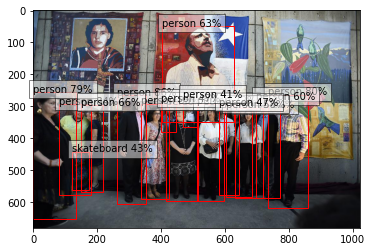

processing time:  7.48263692855835 s


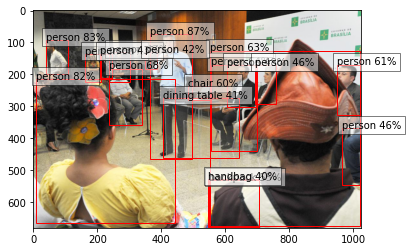

processing time:  8.124564170837402 s


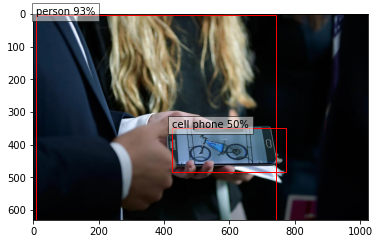

processing time:  6.4027626514434814 s


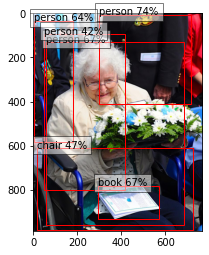

In [11]:
# 运行在测试样例上的检测

import matplotlib.patches as patches
# 加载图片
folder = "/content/drive/My Drive/test_image/"
list_of_test_data = [f for f in os.listdir(folder) if f.endswith('.jpg')]
images = []
for image_path in list_of_test_data:
    photo_filename = folder + image_path
    images.append(read_image_bgr(photo_filename))

for image in images:
  # 复制图片以显示
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # 网络图像预处理
  image = preprocess_image(image)
  image, scale = resize_image(image)
  fig, ax = plt.subplots(1)
  ax.imshow(draw)

  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start,'s')

  # 纠正图像比例
  boxes /= scale

  # 可视化检测结果
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # 分数是排序的，所以我们可以中断（不大于于0.4时）
      if score <= 0.4:
          break
      
      box = box.astype(int)
      left, bot, right, top = box
      x, y, w, h = [val for val in [left, bot, right - left, top - bot]]
      rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      ax.text(x, y, "{} {:.0f}%".format(labels_to_names[label], score*100), bbox=dict(facecolor='white', alpha=0.5))
  plt.show()